# Chapter 4: Development of Beam Equations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

sp.init_printing()
%matplotlib inline

## Steps for FEA

1. Discretize and select the element types
1. Select Displacement Function
1. Define the strain/displacement and stress/strain relationships
1. Derive the element stiffness Matrix and equations
  1. Direct Stiffness Method
  1. Work or Energy Method
  1. Methods of Residuals
1. Assemble the equations to obtain the global or ttoal equations and introduce boundar conditions
1. Solve for unkown degrees of freedom
1. Solve for element strains and stresses
1. Interpret the results

![alt text](under-928246_640.jpg "Image of the beam element with all degrees of freedom")

## Euler Bernoulli beam theory (bending only)
For this theory, we assume that any plane that was perpendicular to the beam's neutral axis prior to deformation will remain perpendicular to the the neutral axis after deformation. This theory is typically sufficient for most loadings

In [2]:
V, w, Fy, x, M, k, YM, rho, MoI, L= sp.symbols('V w(x) F_y x M kappa E rho I L', real=True)
ex, y, u, sigma = sp.symbols('epsilon_x y u sigma', real=True);
a1, a2, a3, a4 = sp.symbols("a_1 a_2 a_3 a_4", real=True)
f0y, f1y, m0, m1, m = sp.symbols("f_{0y} f_{1y} m_0 m_1 m")
vx, v0, v1, phi0, phi1 = sp.symbols('v(x) v_0 v_1 phi_0 phi_1')
sFy = sp.Symbol('\Sigma F_y')
sM2 = sp.Symbol('\Sigma M_2')
dx = sp.Symbol('\Delta x', real=True)
dV = sp.Symbol('\Delta V', real=True)
dM = sp.Symbol("\Delta M", real=True)

### Summation of vertical forces

In [3]:
sp.Eq(sFy, 0)

In [4]:
eqn = sp.Eq(V,(V+dV)+w*dx)
eqn

In [5]:
sp.Eq(w,sp.solveset(f=eqn, symbol=w, domain=sp.S.Reals).args[0])

Now we take $\lim_{\Delta x \to 0}$

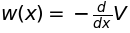

In [6]:
sp.Eq(w,-sp.Derivative(V,x))

### Summation of moments

In [7]:
sp.Eq(sM2)

In [8]:
eqn = sp.Eq(M + V*dx, M+dM + w*dx*dx/2)
eqn

In [9]:
eqn = -V*dx + dM + w*dx*dx/2
eqn = eqn/dx
sp.Eq(eqn.simplify())

taking $\lim_{\Delta x \to 0}$

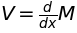

In [10]:
eqn = sp.Eq(V,sp.Derivative(M,x))
eqn

### Recalling curvatures

In [11]:
eqn = sp.Eq(k, 1/rho)
eqn

In [12]:
eqn = sp.Eq(1/rho, M/(YM*MoI))
eqn

also, recalling the formula for calculating the radius of curveature

In [13]:
eqn

realize that $v' = \phi$ and we are assuming small angles so $v'^2 \approx 0$

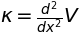

In [14]:
eqn = sp.Eq(k, sp.Derivative(V,x,x));
eqn

giving us the expression

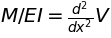

In [15]:
eqn = sp.Eq(M/(YM*MoI),sp.Derivative(V,x,x));
eqn

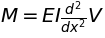

In [16]:
eqn = sp.Eq(M, YM*MoI*sp.Derivative(V,x,x))
eqn

### Back substituting

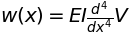

In [17]:
eqn = sp.Eq(w,YM*MoI*sp.Derivative(V,x,x,x,x) )
eqn

assuming only nodal loads

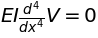

In [18]:
eqn = sp.Eq(YM*MoI*sp.Derivative(V,x,x,x,x))
eqn

## Now we will go through the steps for performing FEA

### Step 1: Select the element type:
We have chosen to use the Beam element with modeling of Euler-Bernouli

### Step 2: Select a displacement Function

In [19]:
eqn = sp.Eq(vx, a1*x**3 + a2*x**2 + a3*x + a4)
eqn

In [20]:
v = a1*x**3 + a2*x**2 + a3*x + a4

Now to enforce the following boundary conditions to determine the coefficients
1. $v(x=0) = v_0$
1. $v'(x=0) = \phi_0$
1. $v(x=L) = v_1$
1. $v'(x=L) = \phi_1$

In [21]:
v = v.subs({a4:sp.solveset(v.subs({x:0})-v0, a4).args[0]})
eqn = sp.Eq(vx, v)
eqn

In [22]:
v = v.subs({a3:sp.solveset(v.diff(x).subs({x:0})-phi0, a3).args[0]})
eqn = sp.Eq(vx, v)
eqn

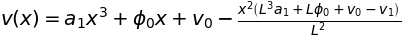

In [23]:
v = v.subs({a2:sp.solveset(sp.Eq(v1,v.subs({x:L})),a2).args[0]});
eqn = sp.Eq(vx,v);
eqn

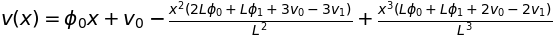

In [24]:
v=v.subs({a1:sp.solveset(sp.Eq(phi1,sp.diff(v,x).subs({x:L})),a1).args[0]});
eqn = sp.Eq(vx,v);
eqn

collecting terms

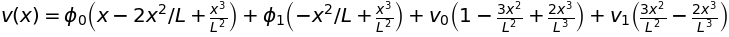

In [25]:
v = sp.collect(sp.expand(v),[v0, phi0, v1, phi1]);
eqn=sp.Eq(vx,v)
eqn

Converting to matrix notation

In [26]:
d = sp.Matrix([v0, phi0, v1, phi1]);
N,B=sp.linear_eq_to_matrix([v],[v0, phi0, v1, phi1]);
del(B)
eqn = sp.Eq(sp.Matrix([vx]),sp.MatMul(N,d))
eqn

                                                                  ⎡v₀⎤
         ⎡       2      3         2    3     2      3     2    3⎤ ⎢  ⎥
         ⎢    3⋅x    2⋅x       2⋅x    x   3⋅x    2⋅x     x    x ⎥ ⎢φ₀⎥
[v(x)] = ⎢1 - ──── + ────  x - ──── + ──  ──── - ────  - ── + ──⎥⋅⎢  ⎥
         ⎢      2      3        L      2    2      3     L     2⎥ ⎢v₁⎥
         ⎣     L      L               L    L      L           L ⎦ ⎢  ⎥
                                                                  ⎣φ₁⎦

### Step 3: Define the Strain/Displacement and Stress/Strain Relationship

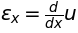

In [27]:
eqn = sp.Eq(ex,sp.Derivative(u,x));
eqn

![alt text](under-928246_640.jpg "Image of the deformed beam explaining the relationship between du/dx and y*dv/dx")

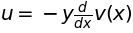

In [28]:
eqn = sp.Eq(u, -y*sp.Derivative(vx,x));
eqn

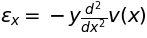

In [29]:
eqn = sp.Eq(ex, -y*sp.Derivative(vx,x,x));
eqn

recall

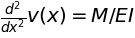

In [30]:
sp.Eq(sp.Derivative(vx,x,x), M/(YM*MoI))

and

In [31]:
sp.Eq(sigma, YM*ex)

In [32]:
sp.Eq(sigma,-y*M/MoI)

### Step 4: Derive the Element Stiffness Matrix and Equations

recall

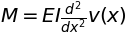

In [33]:
sp.Eq(M,YM*MoI*sp.Derivative(vx,x,x))

and

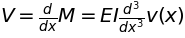

In [34]:
sp.Eq(V,sp.Eq(sp.Derivative(M,x),YM*MoI*sp.Derivative(vx,x,x,x)))

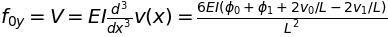

In [35]:
eqn1 = YM*MoI*v.diff(x,x,x);
sp.Eq(
    f0y, sp.Eq(
        V,sp.Eq(
            YM*MoI*sp.Derivative(vx,x,x,x), eqn1
        )
    )
)

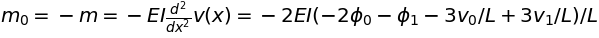

In [36]:
eqn2 = -YM*MoI*v.diff(x,x).subs({x:0})
sp.Eq(
    m0, -sp.Eq(
        m,-sp.Eq(
            YM*MoI*sp.Derivative(vx,x,x), eqn2
        )
    )
)

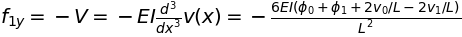

In [37]:
eqn3 = -YM*MoI*v.diff(x,x,x)
sp.Eq(
    f1y, -sp.Eq(
        V,-sp.Eq(
            YM*MoI*sp.Derivative(vx,x,x,x), eqn3
        )
    )
)

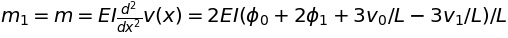

In [38]:
eqn4 = YM*MoI*v.diff(x,x).subs({x:L});
sp.Eq(
    m1, sp.Eq(
        m,sp.Eq(
            YM*MoI*sp.Derivative(vx,x,x), eqn4
        )
    )
)

In [39]:
k,f = sp.linear_eq_to_matrix([eqn1.expand()-f0y, eqn2.expand()-m0, eqn3.expand()-f1y, eqn4.expand()-m1], [v0, phi0,v1, phi1])
sp.Eq(f,sp.MatMul(k,d))

           ⎡ 12⋅E⋅I    6⋅E⋅I   -12⋅E⋅I    6⋅E⋅I ⎤     
           ⎢ ──────    ─────   ────────   ───── ⎥     
           ⎢    3         2        3         2  ⎥     
           ⎢   L         L        L         L   ⎥     
           ⎢                                    ⎥     
           ⎢ 6⋅E⋅I     4⋅E⋅I   -6⋅E⋅I     2⋅E⋅I ⎥     
⎡f_{0y}⎤   ⎢ ─────     ─────   ───────    ───── ⎥ ⎡v₀⎤
⎢      ⎥   ⎢    2        L         2        L   ⎥ ⎢  ⎥
⎢  m₀  ⎥   ⎢   L                  L             ⎥ ⎢φ₀⎥
⎢      ⎥ = ⎢                                    ⎥⋅⎢  ⎥
⎢f_{1y}⎥   ⎢-12⋅E⋅I   -6⋅E⋅I    12⋅E⋅I   -6⋅E⋅I ⎥ ⎢v₁⎥
⎢      ⎥   ⎢────────  ───────   ──────   ───────⎥ ⎢  ⎥
⎣  m₁  ⎦   ⎢    3         2        3         2  ⎥ ⎣φ₁⎦
           ⎢   L         L        L         L   ⎥     
           ⎢                                    ⎥     
           ⎢ 6⋅E⋅I     2⋅E⋅I   -6⋅E⋅I     4⋅E⋅I ⎥     
           ⎢ ─────     ─────   ───────    ───── ⎥     
           ⎢    2        L         2        L   ⎥     
          